###Install packages###


In [379]:
!pip3 install pgmpy
!pip3 install pycountry_convert

#Preprocessing Data#

---

In [380]:
from google.colab import drive
drive.mount('/content/dirve')

Drive already mounted at /content/dirve; to attempt to forcibly remount, call drive.mount("/content/dirve", force_remount=True).


In [381]:
import pandas as pd
import numpy as np
import pycountry_convert as pc
import matplotlib.pyplot as plt

###Supplementary functions###


In [382]:
#Function to convert country name into continent name
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
#Save table of dataframe as image
def save_table(data, name_table,col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    ax.get_figure().savefig(name_table)


###Functions for processing raw data and store###

In [383]:
def read_data():
  #Read raw data
  host_raw_data = pd.read_csv("/content/dirve/MyDrive/HK203/discrete structure/Assignment/data world cup/WorldCups.csv")
  player_raw_data = pd.read_csv("/content/dirve/MyDrive/HK203/discrete structure/Assignment/data world cup/all-world-cup-players.csv")
  match_raw_data = pd.read_csv("/content/dirve/MyDrive/HK203/discrete structure/Assignment/data world cup/WorldCupMatches.csv")
  return host_raw_data, player_raw_data, match_raw_data
host_raw_data, player_raw_data, match_raw_data = read_data()

In [384]:
match_raw_data
match_raw_data.loc[823, 'Home Team Name']

'Germany'

In [385]:
#Becasue this is a discrete model, we decide to divide 2 parts on the age     #
#       + High: When mean(age) < age                                          #
#       + Low: when age < mean(age)                                           #
###############################################################################
def calculate_age_of_player_raw(player_raw):
  player_raw['BornYear'] = player_raw['DateOfBirth'].str[:4]
  player_raw['BornYear'] = pd.to_numeric(player_raw['BornYear'], errors='coerce').astype("Float64")
  mean_year = player_raw['BornYear'].mean()
  player_raw['BornYear'].fillna(mean_year)
  player_raw['Age'] = player_raw['Year'] - player_raw['BornYear']
  mean_age = player_raw['Age'].mean()
  #Calculate average of each country through years
  player = pd.DataFrame()
  year_wc = player_raw['Year'].unique()
  count = 0
  for i in range(len(year_wc)):
    list_players = player_raw[(player_raw['Year'] == year_wc[i])]
    #Divide following country
    country_unique = list_players['Team'].unique()
    for j in range(len(country_unique)):
      iter_country = list_players[(list_players['Team'] == country_unique[j])]
      player.loc[count, 'Year'] = year_wc[i]
      player.loc[count, 'Team'] = country_unique[j]
      if iter_country['Age'].mean() > mean_age:
        player.loc[count, 'Age'] = 'High'
      else:
        player.loc[count, 'Age'] = 'Low'
      count = count + 1 
  return player

age_average = calculate_age_of_player_raw(player_raw_data)

In [386]:
age_average

,Year,Team,Age
0,1930.0,Argentina,Low
1,1930.0,Chile,Low
2,1930.0,France,Low
3,1930.0,Mexico,Low
4,1930.0,Yugoslavia,Low
...,...,...,...
420,2014.0,United States,High
421,2014.0,Algeria,Low
422,2014.0,Belgium,Low
423,2014.0,Russia,High


In [387]:
def processing_data(host_raw, player_data, match_raw):
  #convert continent in worldcup.csv and rename country
  rename_country = ['England', 'Korea/Japan', 'Yugoslavia', 'Czechoslovakia', 'Dutch East Indies', 'Scotland', 'Germany FR', 'Korea Republic', 
                    'Soviet Union', 'Wales', 'Northern Ireland', 'Korea DPR', 'German DR', 'Zaire', 'IR Iran', 'rn">United Arab Emirates', 'rn">Republic of Ireland',
                    'China PR', 'rn">Trinidad and Tobago', "C�te d'Ivoire", 'rn">Serbia and Montenegro', 'rn">Bosnia and Herzegovina']
  new_name_country = ['United Kingdom', 'Japan', 'Serbia', 'Slovakia', 'Indonesia', 'United Kingdom', 'Germany', 'South Korea', 'Russia', 
                      'United Kingdom','United Kingdom', 'South Korea', 'Germany', 'Democratic Republic of the Congo', 'Iran', 'United Arab Emirates', 'United Kingdom',
                      'China', 'Trinidad and Tobago', 'Ivory Coast', 'Serbia', 'Bosnia and Herzegovina']
  for i in range(len(rename_country)):
    host_raw['Country'] = host_raw['Country'].replace(rename_country[i], new_name_country[i])
    match_raw['Home Team Name'] = match_raw['Home Team Name'].replace(rename_country[i], new_name_country[i])
    match_raw['Away Team Name'] = match_raw['Away Team Name'].replace(rename_country[i], new_name_country[i])
    age_average['Team'] =  match_raw['Away Team Name'].replace(rename_country[i], new_name_country[i])
  for i in range(len(host_raw['Country'])):
    host_raw.loc[i,'Continent'] = country_to_continent(host_raw.loc[i, 'Country'])
  #conver continent and add host, average age, total goal for each match for home teamin world cup match.csv
  misssing_value = 0
  for i in range(len(match_raw['Year'])):
    match_raw.loc[i, 'continent_home_team'] = country_to_continent(match_raw.loc[i,'Home Team Name'])
    match_raw.loc[i, 'continent_away_team'] = country_to_continent(match_raw.loc[i,'Away Team Name'])
    #print(age_average.loc[(age_average['Year'] == match_raw.loc[i, 'Year']) & (age_average['Team'] == match_raw.loc[i, 'Home Team Name']),'Age'])
    try:
      match_raw.loc[i, 'age_home_team'] = age_average[(age_average['Year'] == match_raw.loc[i, 'Year']) & (age_average['Team'] == match_raw.loc[i, 'Home Team Name'])]['Age'].values
    except:
      misssing_value = misssing_value + 1
      match_raw.loc[i, 'age_home_team'] = 'High'
    try:
      match_raw.loc[i, 'age_away_team'] = age_average[(age_average['Year'] == match_raw.loc[i, 'Year']) & (age_average['Team'] == match_raw.loc[i, 'Away Team Name'])]['Age'].values
    except:
      misssing_value = misssing_value + 1
      match_raw.loc[i, 'age_away_team'] = 'High'
    match_raw.loc[i, 'Host'] = host_raw[(host_raw['Year'] == match_raw.loc[i,'Year'])]['Continent'].values

  print(misssing_value)
  #Construct the final dataset
  data_home = pd.DataFrame()
  data_away = pd.DataFrame()
  dataset = pd.DataFrame()
    #combine data of home team
  data_home['Team'] = match_raw['Home Team Name']
  data_home['Average Age'] = match_raw['age_home_team']
  data_home['Host'] = match_raw['Host'] 
  data_home['Continent'] = match_raw['continent_home_team'] 
  data_home['Goals'] = match_raw['Home Team Goals']
  data_home['Home Team'] = 1
  data_home['Result'] = match_raw['Home won']
    #combine data of away team
  data_away['Team'] = match_raw['Away Team Name']
  data_away['Average Age'] = match_raw['age_away_team']
  data_away['Host'] = match_raw['Host'] 
  data_away['Continent'] = match_raw['continent_away_team'] 
  data_away['Goals'] = match_raw['Away Team Goals']
  data_away['Home Team'] = 0
  data_away['Result'] = match_raw['Away won']
  #Both data_home and data_away
  dataset = pd.concat([data_home, data_away], ignore_index=True)
  return dataset.iloc[np.random.permutation(dataset.index)].reset_index(drop=True) #Shuffle randomly data
dataset = processing_data(host_raw_data, player_raw_data, match_raw_data)

 77%|███████▋  | 110/143 [00:19<00:01, 23.63it/s]

1319


In [388]:
dataset

,Team,Average Age,Host,Continent,Goals,Home Team,Result
0,USA,High,Europe,North America,1,1,lose
1,Argentina,High,Europe,South America,2,0,lose
2,Uruguay,High,South America,South America,1,0,win
3,South Korea,Low,South America,Asia,1,0,draw
4,South Africa,High,Europe,Africa,1,1,draw
...,...,...,...,...,...,...,...
1699,Japan,High,Europe,Asia,0,1,draw
1700,Chile,High,Europe,South America,0,1,lose
1701,Brazil,High,Europe,South America,5,1,win
1702,Costa Rica,High,Asia,North America,2,0,win


In [389]:
#Store prepared data
def save_data(processed_data):
  processed_data.to_csv("/content/dirve/MyDrive/HK203/discrete structure/Assignment/data world cup/prepared_data.csv", index = False)
  return 0
save_data(dataset)

0

#Overview Dataset#

---

In [390]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt; plt.rcdefaults()

In [391]:
pre = pd.read_csv("/content/dirve/MyDrive/HK203/discrete structure/Assignment/data world cup/prepared_data.csv")

Compare the statistics to see which country has won the most compared to the others.

In [392]:
#5a) Compare to see which country has won the most
wins = [0,0,0,0,0,0]
for i in range(len(pre['Host'])):
  if pre.loc[i,'Continent'] == 'Europe' and pre.loc[i,'Result'] == 'win':
    wins[0] += 1
  elif pre.loc[i,'Continent'] == 'South America' and pre.loc[i,'Result'] == 'win':
    wins[1] += 1
  elif pre.loc[i,'Continent'] == 'North America' and pre.loc[i,'Result'] == 'win':
    wins[2] += 1
  elif pre.loc[i,'Continent'] == 'Africa' and pre.loc[i,'Result'] == 'win':
    wins[3] += 1
  elif pre.loc[i,'Continent'] == 'Asia' and pre.loc[i,'Result'] == 'win':
    wins[4] += 1
  elif pre.loc[i,'Continent'] == 'Oceania' and pre.loc[i,'Result'] == 'win':
    wins[5] += 1
wins_array = np.array([wins])
table = pd.DataFrame(wins_array,
             index = ['Number of won matches'],
             columns=['Europe', 'South America', 'North America','Africa','Asia','Oceania'])
print(table)
print('So European teams won the most matches.')

                       Europe  South America  ...  Asia  Oceania
Number of won matches     418            169  ...    18        2

[1 rows x 6 columns]
So European teams won the most matches.


To show the relationships between features selected from the datasheet, we compare the information that we have in many different ways.
For example, we use 4 criterias in the quantity of matches: 
1.   Compare how many matches that teams have high goal rate and low goal rate won to show the difference.
2.   Compare when the host of that season are in the comtinent with teams then how many wins and loses do teams in that continent have.
3.   More specified, compare how many wins and loses do European teams won and lost when playing in Euro.
4.  And compare the loses that teams have to face when scored less than 3 and greater than or equal 3 to show how the scores affected the result.



In [393]:
#Compare data for making graph
high_goal_re = 0
low_goal_re = 0
for i in range(len(pre['Host'])):
  if int(pre.loc[i, 'Goals']) >= 3 and pre.loc[i, 'Result'] == 'lose':
    high_goal_re += 1
  elif int(pre.loc[i, 'Goals']) < 3 and pre.loc[i, 'Result'] == 'lose':
    low_goal_re += 1
conti_in_hostw = 0
conti_in_hostl = 0
for i in range(len(pre['Host'])):
  if pre.loc[i, 'Continent'] ==  pre.loc[i, 'Host'] and pre.loc[i, 'Result'] == 'win':
    conti_in_hostw += 1
  elif pre.loc[i, 'Continent'] ==  pre.loc[i, 'Host'] and pre.loc[i, 'Result'] == 'lose':
    conti_in_hostl += 1
eu_con_homew = 0
eu_con_homel = 0
for i in range(len(pre['Host'])):
  if pre.loc[i, 'Continent'] == 'Europe' and pre.loc[i, 'Home Team'] == 1 and pre.loc[i, 'Result'] == 'win':
    eu_con_homew += 1
  elif pre.loc[i, 'Continent'] == 'Europe' and pre.loc[i, 'Home Team'] == 1 and pre.loc[i, 'Result'] == 'lose':
    eu_con_homel += 1
high_age_w = 0
low_age_w = 0
for i in range(len(pre['Host'])):
  if pre.loc[i, 'Average Age'] == 'High' and pre.loc[i, 'Result'] == 'win':
    high_age_w += 1
  elif pre.loc[i, 'Average Age'] == 'Low' and pre.loc[i, 'Result'] == 'win':
    low_age_w += 1

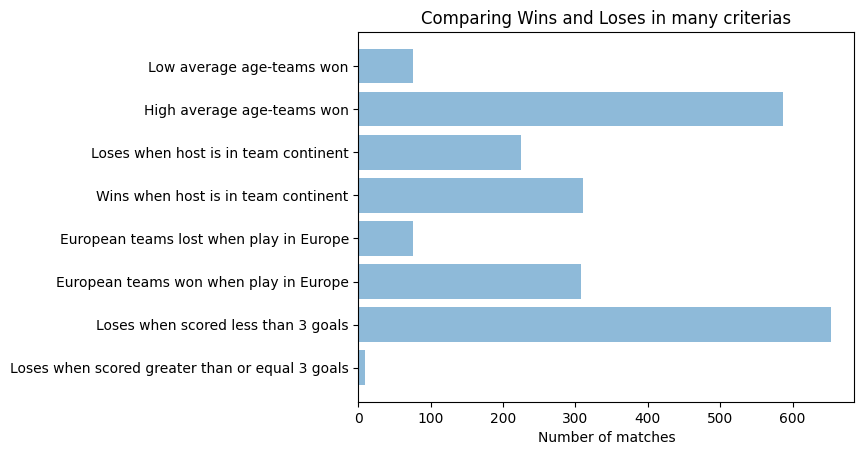

In [394]:
#Drawing graph
objects = ('Loses when scored greater than or equal 3 goals', 'Loses when scored less than 3 goals', 'European teams won when play in Europe', 'European teams lost when play in Europe','Wins when host is in team continent','Loses when host is in team continent','High average age-teams won','Low average age-teams won')
y_pos = np.arange(len(objects))
performance = [high_goal_re,low_goal_re,eu_con_homew,eu_con_homel,conti_in_hostw,conti_in_hostl,high_age_w,low_age_w]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Number of matches')
plt.title('Comparing Wins and Loses in many criterias')
#plt.savefig("compare_win_lose.png", bbox_inches="tight")
plt.show()

#Bayesian Model using estimator Maximum Likelihood#

---

In [395]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianModel

In [396]:
# #Read dataset
# dataset = pd.read_csv("/content/drive/MyDrive/HK203/discrete structure/Assignment/data world cup/prepared_data.csv")
wc_2018 = pd.read_csv("/content/dirve/MyDrive/HK203/discrete structure/Assignment/data world cup/wc_2018.csv")

In [397]:
def split_data(dataset):
    train_data = dataset.iloc[:int(0.8*len(dataset)),1:]
    test_data = dataset.iloc[int(0.8*len(dataset)):,:]
    return train_data, test_data
train_data, test_data = split_data(dataset)
train_data

,Average Age,Host,Continent,Goals,Home Team,Result
0,High,Europe,North America,1,1,lose
1,High,Europe,South America,2,0,lose
2,High,South America,South America,1,0,win
3,Low,South America,Asia,1,0,draw
4,High,Europe,Africa,1,1,draw
...,...,...,...,...,...,...
1358,High,Europe,South America,0,1,lose
1359,High,Europe,South America,2,0,lose
1360,High,South America,Europe,2,1,win
1361,High,Europe,Europe,1,1,win


In [398]:
test_data

,Team,Average Age,Host,Continent,Goals,Home Team,Result
1363,France,High,Europe,Europe,1,1,win
1364,Brazil,High,Europe,South America,3,1,win
1365,United Kingdom,High,Africa,Europe,1,0,win
1366,Chile,High,South America,South America,1,1,win
1367,Austria,High,Europe,Europe,0,0,lose
...,...,...,...,...,...,...,...
1699,Japan,High,Europe,Asia,0,1,draw
1700,Chile,High,Europe,South America,0,1,lose
1701,Brazil,High,Europe,South America,5,1,win
1702,Costa Rica,High,Asia,North America,2,0,win


In [399]:
model = BayesianModel([('Result', 'Average Age'), ('Result', 'Goals'),('Host', 'Result'), ('Host', 'Continent'), ('Continent', 'Home Team'), ('Home Team', 'Result') ])

In [400]:
#data here is the data set stored in pandas dataframe format
model.fit(train_data, estimator = MaximumLikelihoodEstimator)

In [401]:
#print the probability distribution at node Result after estimating
def get_cpd(node, model): 
  node_dis = model.get_cpds(node)
  print(node_dis)
  return node_dis

get_cpd('Goals', model)

+-----------+----------------------+----------------------+----------------------+
| Result    | Result(draw)         | Result(lose)         | Result(win)          |
+-----------+----------------------+----------------------+----------------------+
| Goals(0)  | 0.39464882943143814  | 0.5141242937853108   | 0.0                  |
+-----------+----------------------+----------------------+----------------------+
| Goals(1)  | 0.411371237458194    | 0.3785310734463277   | 0.23639774859287055  |
+-----------+----------------------+----------------------+----------------------+
| Goals(2)  | 0.1605351170568562   | 0.09227871939736347  | 0.33771106941838647  |
+-----------+----------------------+----------------------+----------------------+
| Goals(3)  | 0.023411371237458192 | 0.011299435028248588 | 0.23639774859287055  |
+-----------+----------------------+----------------------+----------------------+
| Goals(4)  | 0.010033444816053512 | 0.0                  | 0.10881801125703565  |
+---

<TabularCPD representing P(Goals:11 | Result:3) at 0x7ff09f840d90>

## MODEL PERFROMANCE ##

---


#### **PRECISION AND RECALL** ##
---
$Precision$ $=$ $\frac{TP}{TP+FP}$ 
\
\
$Recall$ $=$ $\frac{TP}{TP+FN}$


In this case, our model give 3 results which are Win, Lose, Draw. So we need to consider confusion matrix 3x3 instead of matrix 2x2.

---

$Precision = \frac{True\_Win}{Total\_of\_cases\_predicted\_Win}$ 
\
\
$Recall = \frac{True\_Win}{Total\_of\_cases\_predicted\_True}$ (These case are Win-Win, Lose-Lose, Drawn-Drawn)





In [402]:
test_data

,Team,Average Age,Host,Continent,Goals,Home Team,Result
1363,France,High,Europe,Europe,1,1,win
1364,Brazil,High,Europe,South America,3,1,win
1365,United Kingdom,High,Africa,Europe,1,0,win
1366,Chile,High,South America,South America,1,1,win
1367,Austria,High,Europe,Europe,0,0,lose
...,...,...,...,...,...,...,...
1699,Japan,High,Europe,Asia,0,1,draw
1700,Chile,High,Europe,South America,0,1,lose
1701,Brazil,High,Europe,South America,5,1,win
1702,Costa Rica,High,Asia,North America,2,0,win


In [403]:
#Predict test_data
predict = model.predict(test_data.drop(columns=['Result', 'Team']))
predict


100%|██████████| 145/145 [00:05<00:00, 27.57it/s]


,Result
0,win
1,win
2,lose
3,win
4,lose
...,...
336,draw
337,draw
338,win
339,win


In [404]:
def evaluate_performance(predict_data, true_data):
  true_answers = 0
  a = true_data.values
  fw = 0 #False win (lose)
  fw2 = 0 #False win (drawn)
  tw = 0 #True win
  tl = 0 #True lose
  td = 0 #True drawn
  fl = 0 #False negative
  for i in range(len(a)):
    if predict_data[i] == 'win' and a[i] == 'win':
      tw = tw + 1
      true_answers = true_answers + 1
    elif predict_data[i] == 'win' and a[i] == 'lose':
      fw = fw + 1  
    elif predict_data[i] == 'win' and a[i] == 'draw':
      fw2 = fw2 + 1
    elif predict_data[i] == 'lose' and a[i] == 'lose':
      tl = tl + 1
      true_answers = true_answers + 1
    elif predict_data[i] == 'draw' and a[i] == 'draw':
      td = td + 1
      true_answers = true_answers + 1
  #Calculate precision and recall
  precision = tw/(tw + fw + fw2)
  recall = tw/(tw + tl + td)
  accuracy = true_answers/len(a)
  print("accuracy = {0:.2f}%".format(accuracy*100))
  print("precision = {0:.2f}%".format(precision*100)) 
  print("recall = {0:.2f}%".format(recall*100))
evaluate_performance(predict.values, test_data['Result'])

accuracy = 63.34%
precision = 71.61%
recall = 51.39%


##Adjust Model## 

In [405]:
model2 = BayesianModel([('Goals','Average Age'),('Result', 'Average Age'),('Result', 'Goals'),('Goals', 'Host'),
                        ('Host', 'Continent'), ('Result', 'Home Team'),('Continent', 'Home Team')])

In [406]:
#data here is the data set stored in pandas dataframe format
model2.fit(train_data, estimator = MaximumLikelihoodEstimator)

In [407]:
#Predict test_data
predict2 = model2.predict(test_data.iloc[:,1:6]).values


100%|██████████| 145/145 [00:02<00:00, 52.75it/s]


In [408]:
evaluate_performance(predict2,test_data['Result'])

accuracy = 61.29%
precision = 68.79%
recall = 51.67%


As we can see, after trying reconstruct model, the first model is still better than the other. Thus, we keep the first model for predicting 

##Predict Result##

###Predict championshiop of world cup 2018###

In [409]:
rate_win_country = pd.DataFrame()
rate_win = model.predict_probability(wc_2018.drop(columns = ['Team']))['Result_win'].values
rate_win_country['Team'] = wc_2018['Team']
rate_win_country['Winning Probability'] = rate_win.round(decimals=4)
rate_win_country = rate_win_country.sort_values(by=['Winning Probability'],ascending = False , ignore_index = True)
rate_win_country

,Team,Winning Probability
0,Argentina,0.4530
1,Brazil,0.4530
2,Colombia,0.4530
3,Uruguay,0.4530
4,Peru,0.4505
5,Poland,0.4167
6,Portugal,0.4167
7,Russia,0.4167
8,Spain,0.4167
9,Sweden,0.4167


In [410]:
# #Save table
# save_table(rate_win_country, "rate_winning_wc_2018.png")

In [411]:
print("The predicted winner: ", rate_win_country.loc[0,'Team'])
print("The predicted runner-up: ", rate_win_country.loc[1,'Team'])
print("The predicted third place: ", rate_win_country.loc[2,'Team'])
print("The predicted fourth place: ", rate_win_country.loc[3,'Team'])

The predicted winner:  Argentina
The predicted runner-up:  Brazil
The predicted third place:  Colombia
The predicted fourth place:  Uruguay


###Predict the winner in a match

In [412]:
#Compare Win Rate between 2 teams
def compare(home_win_rate, away_win_rate):
  #Win rate
  #infer = VariableElimination(model)
  if home_win_rate['Result_win'].values > away_win_rate['Result_win'].values:
    return 'win'
  elif home_win_rate['Result_win'] < away_win_rate['Result_win'].values:
    return 'lose'
  else:
    return 'draw'
def expected_goal_scores(team):
  expected_goal = 0
  for i in range(len(team.iloc[0,:len(team)-4])):
    expected_goal = expected_goal + i*team.iloc[0,i]
  return expected_goal.astype("Int64")

def winner(home_team, away_team, wc_2018, model):
  #Construct home team list
  home = wc_2018[(wc_2018['Team'] == home_team )].drop(columns = ['Team'])
  home['Home Team'] = 1
  #Construct away team list 
  away = wc_2018[(wc_2018['Team'] == away_team)].drop(columns = ['Team'])
  away['Home Team'] = 0
  home_win_rate = model.predict_probability(home)
  away_win_rate = model.predict_probability(away)
  result = compare(home_win_rate, away_win_rate)
  print("______________________________________")
  print("|",home_team," ", result, " ", away_team,"           ")
  print("|with the final score of match: %d - %d " %(expected_goal_scores(home_win_rate),expected_goal_scores(away_win_rate)))
  print("______________________________________")

In [413]:
#Type your home team and away team that you want to compare
winner('Brazil', 'Belgium', wc_2018, model)

______________________________________
| Brazil   win   Belgium            
|with the final score of match: 1 - 0 
______________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:

Numeric-style type codes are deprecated and will result in an error in the future.

